# 피쳐 추출 및 생성
### 사용 라이브러리

In [2]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import re
from fuzzywuzzy import process
from collections import defaultdict

from scipy.stats import pearsonr

### 데이터 불러오기

In [3]:
# 전처리 완료한 데이터 불러오기
vehicle_df = pd.read_parquet('./data/vehicle_preprocessed.parquet')

## 피쳐 엔지니어링

### 1) Odometer와 Model_year의 상관관계
"생산연도가 오래될 수록 (연식이 오래됬을수록) 주행거리가 높다"라는 가설을 세우고 확인해보겠습니다.

만약 둘 사이의 상관관계가 높다면 굳이 두 컬럼 다 피쳐로 포함시킬 필요는 없습니다.

Correlation coefficient: 0.2849943068228018
p-value: 0.023577343558734365


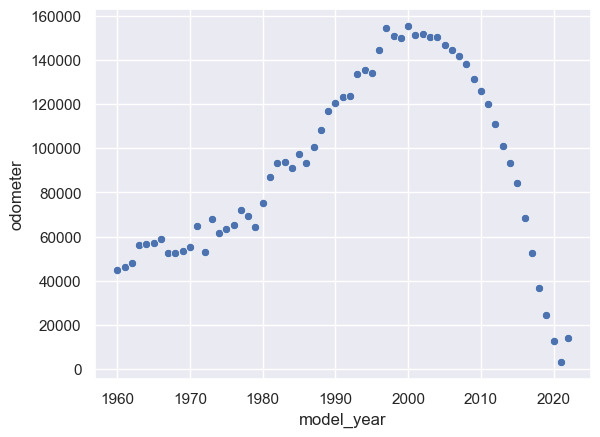

In [4]:
# 생산 연도별 평균 주행거리 계산
odometer_by_year = pd.DataFrame(vehicle_df.groupby('model_year')['odometer'].mean()).reset_index()

# 상관계수와 p-값 계산
corr, p_value = pearsonr(odometer_by_year['model_year'].values, odometer_by_year['odometer'])

print(f"Correlation coefficient: {corr:}")
print(f"p-value: {p_value:}")

# 상관관계 시각화
sns.scatterplot(data=odometer_by_year, x='model_year', y='odometer')
plt.show()

상관계수가 0.2716으로 높은 편은 아닙니다.

시각화를 했을 때, 2021년부터 2020년까지는 음의 상관관계를 보여주나, 그 이전 데이터는 양의 상관관계를 보여주는 것을 볼 수 있습니다.

두 데이터의 패턴이 다르기 때문에, 두 종류에 데이터에 같은 모델을 적용할 시 정확도가 낮아질 수 있습니다.

그러므로 데이터를 나눠주도록 하겠습니다.

In [5]:
# 2000년을 기준으로 나눈 데이터 개수 확인
print(f"2000년 이후 생산된 차량 개수: {vehicle_df[vehicle_df['model_year'] >= 2000].shape[0]:}")
print(f"2000년 이전 생산된 차량 개수: {vehicle_df[vehicle_df['model_year'] < 2000].shape[0]:}")

2000년 이후 생산된 차량 개수: 341808
2000년 이전 생산된 차량 개수: 17183


두 종류에 데이터에 대해 모델을 둘 다 구축하는 것이 맞지만, 좀 더 데이터가 많고,\
구매자가 좀 더 관심이 많을 2000년 이후 데이터를 가지고 모델을 구축해 보도록 하겠습니다.

위에서 진행한 상관관계 분석을 다시 적용해 보겠습니다.

Correlation coefficient: -0.9544327860481832
p-value: 1.6813456371702752e-12


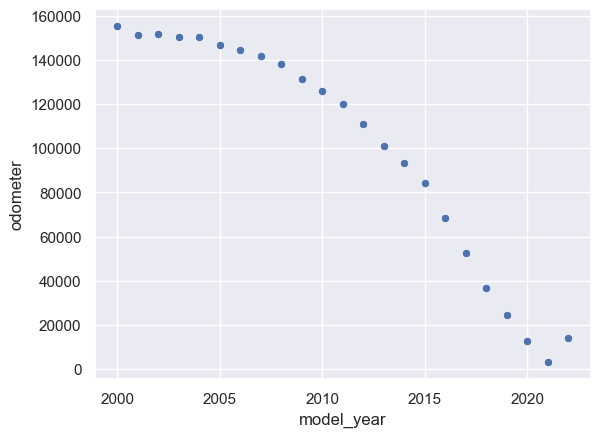

In [6]:
# 2000년 이후 생산된 차량만 추출
vehicle_post_2000 = vehicle_df[vehicle_df['model_year'] >= 2000]

# 생산 연도별 평균 주행거리 계산
odometer_by_year_post_2000 = pd.DataFrame(vehicle_post_2000.groupby('model_year')['odometer'].mean()).reset_index()

# 상관계수와 p-값 계산
corr, p_value = pearsonr(odometer_by_year_post_2000['model_year'].values, odometer_by_year_post_2000['odometer'])
print(f"Correlation coefficient: {corr:}")
print(f"p-value: {p_value:}")

# 상관관계 시각화
sns.scatterplot(data=odometer_by_year_post_2000, x='model_year', y='odometer')
plt.show()

상관계수는 -0.96, p-value는 2.65e-13로 상관관계가 뚜렷이 나타나는 것을 볼 수 있습니다.

### 2) Odometer와 Model Year를 이용한 파생변수 생성
차를 살때 사람들이 또 중요하게 생각하는 변수가 주행거리를 생산연도로 나눈 값입니다.

https://post.naver.com/viewer/postView.nhn?volumeNo=28822704

이 값은 차 소유자가 차를 평균적으로 1년에 얼마나 주행했는지를 알려줍니다.

In [9]:
# 연식 대비 주행거리 계산
vehicle_post_2000['odometer_per_age'] = vehicle_post_2000['odometer'] / (2023 - vehicle_post_2000['model_year'])

vehicle_post_2000['odometer'].describe()

count    341808.000000
mean      89878.119310
std       60123.369073
min           0.000000
25%       36970.000000
50%       85000.000000
75%      132469.000000
max      281941.000000
Name: odometer, dtype: float64

In [11]:
# IQR을 이용한 이상치 제거
Q1 = vehicle_post_2000['odometer_per_age'].quantile(0.25)
Q3 = vehicle_post_2000['odometer_per_age'].quantile(0.75)
IQR = Q3 - Q1

# Q1 / Q3에서 1.5 * IQR 이상 벗어난 값 제거
vehicle_filtered = vehicle_post_2000[(vehicle_post_2000['odometer_per_age'] >= Q1 - 1.5 * IQR) & (vehicle_post_2000['odometer_per_age'] <= Q3 + 1.5 * IQR)]

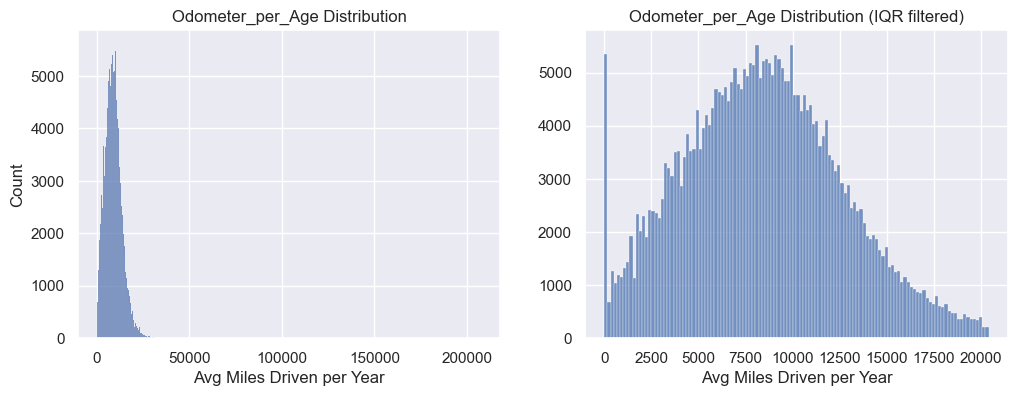

In [13]:
# 연식 대비 주행거리 분포 시각화
fig, axis = plt.subplots(1, 2, figsize=(12, 4))

# histplot 그리기
sns.histplot(vehicle_post_2000['odometer_per_age'], ax=axis[0])
axis[0].set_title('Odometer_per_Age Distribution')
axis[0].set_xlabel('Avg Miles Driven per Year')

# IQR로 이상치를 제거한 데이터의 histplot 그리기
sns.histplot(vehicle_filtered['odometer_per_age'], ax=axis[1])
axis[1].set_title('Odometer_per_Age Distribution (IQR filtered)')
axis[1].set_xlabel('Avg Miles Driven per Year')
axis[1].set_ylabel('')

plt.show()

### 3) 차량 도난률 데이터 병합
판매 지역의 차량 도난률이 차량 가격에 영향을 미치는 지 알고 싶었습니다.

미국 지역별 범죄 데이터를 가지고 와서 인구별 차량 도난률 (autoTheftPerPop)을 데이터에 추가해 주도록 하겠습니다.


In [14]:
# 지역별 차량 도난률 데이터 불러오기
crime_data = pd.read_csv('./data/crimedata.csv', usecols=['communityName', 'state', 'population', 'autoTheftPerPop'])

crime_data.head()

,communityName,state,population,autoTheftPerPop
0,BerkeleyHeightstownship,NJ,11980,131.26
1,Marpletownship,PA,23123,110.55
2,Tigardcity,OR,29344,376.30
3,Gloversvillecity,NY,16656,271.93
4,Bemidjicity,MN,11245,728.93


In [15]:
# 이름 간편하게 변경
vehicle_df = vehicle_filtered.copy()

#### Community Name 컬럼 정리

In [17]:
#  communityName 컬럼에서 지역명을 추출하는 함수
def clean_community_name(name):
    suffixes = ['city', 'town', 'township', 'division', 'district', 'borough', 'village']
    for suffix in suffixes:
        if name.lower().endswith(suffix):
            name = name[:-(len(suffix))]
    return name.lower()

# communityName 컬럼을 정제하여 cleanedCommunityName 컬럼을 생성
crime_data['cleanedCommunityName'] = crime_data['communityName'].apply(clean_community_name)

# 예시 샘플 3개 출력
crime_data[['communityName', 'cleanedCommunityName']].sample(3)

,communityName,cleanedCommunityName
329,Paradisetown,paradise
1251,LaMiradacity,lamirada
1226,Lislevillage,lisle


범죄와 차량 정보 데이터프레임에서 각각 지역명과 주 이름을 따와 딕셔너리 생성

In [18]:
# 합병할 데이터프레임의 'state' 컬럼을 소문자로 변경
crime_data['state'] = crime_data['state'].str.lower()
vehicle_df['state'] = vehicle_df['state'].str.lower()

# 'state'과 'cleanedCommunityName' 컬럼을 딕셔너리로 변환
crime_state_dict = crime_data.groupby('state')['cleanedCommunityName'].apply(list).to_dict()

# 'state'과 'region' 컬럼을 딕셔너리로 변환
vehicle_region_state_dict = vehicle_df.set_index('region')['state'].to_dict()

두 딕셔너리 내의 일치하는 값을 매핑

In [19]:
def enhance_matching(vehicle_dict, crime_dict, manual_mappings):
    matched_dict = defaultdict(list)

    # 복잡한 매핑에선 수동 매핑을 우선적으로 적용
    for region, state in vehicle_dict.items():
        if region in manual_mappings:
            matched_dict[region].append(manual_mappings[region])
            continue
        
        # 지역명을 토큰화하여 일치하는 지역을 찾음
        key_parts = [token.strip() for token in re.split('[-/ ]', region) if token.strip()]
        if state in crime_dict:
            for part in key_parts:
                # fuzzywuzzy를 사용하여 일치하는 지역명을 찾음
                matches = process.extractBests(part, crime_dict[state], score_cutoff=75)
                for match, score in matches:
                    matched_dict[region].append(match)

    return matched_dict

# ChatGPT의 도움을 받아 지리적 데이터를 기반으로 매핑을 개선
manual_mappings = {
    'southeast alaska': 'juneau',
    'humboldt county': 'eureka',
    'mendocino county': 'ukiah',
    'northwest CT': 'torrington',
    'delaware': 'dover',
    'space coast': 'melbourne',
    'lewiston / clarkston': 'lewiston',
    'bloomington-normal': 'bloomington',
    'southeast IA': 'burlington',
    'southeast KS': 'pittsburg',
    'western KY': 'paducah',
    'central louisiana': 'alexandria',
    'maine': 'augusta',
    'cumberland valley': 'harrisburg',
    'eastern shore': 'salisbury',
    'western maryland': 'cumberland',
    'cape cod / islands': 'barnstable',
    'southwest michigan': 'kalamazoo',
    'upper peninsula': 'marquette',
    'southwest MN': 'marshall',
    'north mississippi': 'tupelo',
    'southwest MS': 'natchez',
    'central NJ': 'trenton',
    'catskills': 'kingston',
    'finger lakes': 'geneva',
    'hudson valley': 'poughkeepsie',
    'new hampshire': 'concord',
    'north dakota': 'bismarck',
    'northern panhandle': 'wheeling',
    'texoma': 'sherman',
    'rhode island': 'providence',
    'northeast SD': 'aberdeen',
    'south dakota': 'pierre',
    'southwest VA': 'roanoke',
    'eastern panhandle': 'martinsburg',
    'southern WV': 'charleston',
    'west virginia (old)': 'charleston',
    'wyoming': 'cheyenne'
}

# 매핑 진행
enhanced_matches = enhance_matching(vehicle_region_state_dict, crime_state_dict, manual_mappings)

매칭된 딕셔너리를 이용하여 범죄 데이터를 차량 데이터에 합병

In [20]:
# region의 값이 여러개의 지역을 나타낼 시, 각 지역의 autoTheftPerPop의 평균을 계산
region_auto_theft = {}

for region, communities in enhanced_matches.items():
    # 매칭된 지역명에 해당하는 데이터만 추출
    filtered_crime_data = crime_data[crime_data['cleanedCommunityName'].isin(communities)]
    # 매칭된 지역들의 autoTheftPerPop의 평균 계산
    avg_auto_theft = filtered_crime_data['autoTheftPerPop'].mean()
    region_auto_theft[region] = avg_auto_theft

# 딕셔너리를 데이터프레임으로 변환
region_auto_theft_df = pd.DataFrame(list(region_auto_theft.items()), columns=['region', 'avg_autoTheftPerPop'])

# 데이터프레임 병합
merged_data = vehicle_df.merge(region_auto_theft_df, on='region', how='left')

In [21]:
# 차량 도난 데이터가 있는 지역과 없는 지역의 개수 출력
print(f"도난 데이터가 있는 지역의 개수: {merged_data[merged_data['avg_autoTheftPerPop'].notnull()]['region'].nunique():}")
print(f"도난 데이터가 없는 지역의 개수: {merged_data[merged_data['avg_autoTheftPerPop'].isnull()]['region'].nunique():}")

# 차량 도난 데이터 결측치 비율 확인
print(f"결측치 비율: {merged_data['avg_autoTheftPerPop'].isnull().mean():.4f}")

도난 데이터가 있는 지역의 개수: 335
도난 데이터가 없는 지역의 개수: 69
결측치 비율: 0.1098


In [22]:
# 도난 데이터가 없는 지역의 데이터를 제거
merged_data.dropna(subset=['avg_autoTheftPerPop'], inplace=True)

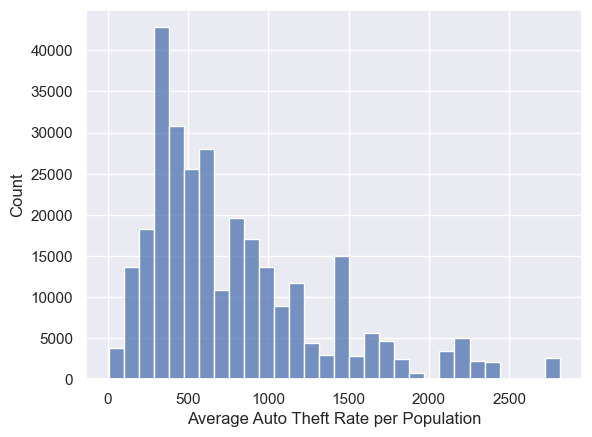

In [26]:
# 도난 데이터 분포 시각화
sns.histplot(merged_data['avg_autoTheftPerPop'], bins=30)
plt.xlabel('Average Auto Theft Rate per Population')
plt.show()

## 데이터 저장

In [25]:
merged_data.to_parquet('./data/vehicle_final.parquet')

---
---